# Импорт модулей

In [1]:
import pandas_datareader as pdr
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline

In [2]:
# Собираем котировки за интересующий период.
start_date = datetime(1990, 11, 27)
end_date = datetime(2019, 11, 27)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


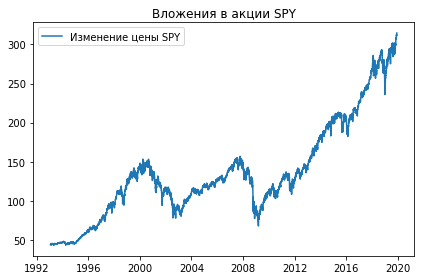

In [3]:
symbols = ["SPY"]
for symbol in symbols:
    df = pdr.get_data_yahoo(symbols=symbol, start=start_date, end=end_date)
    time = [x for x in df.index]
    price = [x for x in df['Open']]
    plt.plot(time, price, label='Изменение цены ' + symbol)

plt.legend()
title = 'Вложения в акции ' + symbol
plt.title(title)
plt.tight_layout()
plt.show()


In [4]:
import yfinance as yf

stock = yf.Ticker(symbol)

# # get stock info
# stock.info

# get historical market data
hist = stock.history(period="max")

# # show actions (dividends, splits)
# stock.actions

# # show dividends
# stock.dividends

# # show splits
# stock.splits

# # show financials
# stock.financials
# stock.quarterly_financials

# # show balance heet
# stock.balance_sheet
# stock.quarterly_balance_sheet

# # show cashflow
# stock.cashflow
# stock.quarterly_cashflow

# # show earnings
# stock.earnings
# stock.quarterly_earnings

# # show sustainability
# stock.sustainability

# # show analysts recommendations
# stock.recommendations

# # show next event (earnings, etc)
# stock.calendar

# # show options expirations
# stock.options



In [5]:
div_data = stock.dividends
div_data = pd.DataFrame(div_data.groupby(div_data.index.year).sum())
div_data = div_data * 0.87

# Импорт курса доллара:

In [6]:
# Выбираем диапазон дат для запроса курса доллара.
start_date = '14.11.2000'
finish_date = '14.11.2019'

#Ссылка на сайт ЦБ РФ.
url = 'http://cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.FromDate='+start_date+'&UniDbQuery.ToDate='+finish_date

# Импортируем данные с ЦБ РФ в Дата-сет.
dollar_rate = pd.read_html(url)

# Выбираем таблицу на сайте ЦБ РФ для обработки.
dollar_rate = pd.DataFrame(dollar_rate[0])

# Указываем имена колонн.
dollar_rate.columns = dollar_rate.loc[1]

# Удаляем первую и вторую строку в дата-сете (мусор).
dollar_rate = dollar_rate.drop([0, 1])

# Удаляем ненужную графу единиц.
del dollar_rate['Единиц']

# Указываем что у курса доллара будет формат FLOAT.
# dollar_rate['Курс'].astype(float)

# Убираем лишние цифры после сотых.
dollar_rate['Курс'] = round(pd.to_numeric(dollar_rate['Курс']) /10000, 2)

# Переименовываем заголовки колонн.
dollar_rate.columns = ['Date', 'Dollar_Rate']

# Сбрасываем индексы от 0 и тд... 
dollar_rate_data = dollar_rate.reset_index()[['Date', 'Dollar_Rate']]

# Задаём фармат datatime графе 'Дата'.
dollar_rate_data['Date'] = pd.to_datetime(dollar_rate_data['Date'])

# Удаляем единичку в шапке над индексами.
del dollar_rate_data.columns.name

# Выводим инфо по таблице с курсом доллара.
print(dollar_rate_data.info())

# Смотрим на таблицу.
dollar_rate_data

# Группируем по годам
usdrub_data = dollar_rate_data.groupby(dollar_rate_data['Date'].dt.year).mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4719 entries, 0 to 4718
Data columns (total 2 columns):
Date           4719 non-null datetime64[ns]
Dollar_Rate    4719 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 73.8 KB
None


In [7]:
df['Date'] = df.index

df = df[['Date', 'Open']]

In [8]:
stock_price = df.groupby(df['Date'].dt.year).mean()

In [9]:
main = pd.merge(stock_price, usdrub_data, left_index=True, right_index=True)

In [10]:
INVEST_IN_MONTH = 10000
INVEST_IN_YEAR = INVEST_IN_MONTH * 12

YEARS = len(main)

main['stocks_count'] =  INVEST_IN_YEAR // main['Dollar_Rate'] // main['Open']

In [11]:
main.index.size

20

In [12]:
for i, row in enumerate(main['stocks_count']):
    if i > 0:
        main.stocks_count.values[i] = main.stocks_count.values[i] + main.stocks_count.values[i - 1]

In [13]:
main = pd.merge(main, div_data, left_index=True, right_index=True)

In [14]:
main['div_pay'] = main.stocks_count * main.Dividends

In [15]:
rest_money = 0
stocks_count = 0
stocks_with_reinvest = []
for i, row in enumerate(main['stocks_count']):
    rest_money += main.div_pay.values[i]
    stocks_count += rest_money // main.Open.values[i]
    stocks_with_reinvest.append(main.stocks_count.values[i] + stocks_count)
    rest_money -= (main.div_pay.values[i] // main.Open.values[i]) * main.Open.values[i]
        
main['stocks_with_reinvest'] = stocks_with_reinvest


In [16]:
(main.div_pay.values[0] // main.Open.values[0]) * main.Open.values[0]

0.0

In [17]:
main.div_pay.values[0]

39.280499999999996

In [18]:
main.div_pay.values[0] % main.Open.values[0]

39.280499999999996

In [19]:
main

,Open,Dollar_Rate,stocks_count,Dividends,div_pay,stocks_with_reinvest
Date,,,,,,
2000,143.139633,27.914412,30.0,1.30935,39.28050,30.0
2001,119.757160,29.175301,64.0,1.23888,79.28832,64.0
2002,99.840317,31.360600,102.0,1.30326,132.93252,104.0
2003,96.877302,30.671680,142.0,1.41810,201.37020,147.0
2004,113.452460,28.808446,178.0,1.91139,340.22742,187.0
2005,120.896389,28.313508,213.0,1.86963,398.23119,227.0
2006,131.126374,27.135202,246.0,2.12802,523.49292,266.0
2007,147.838327,25.551566,277.0,2.34987,650.91399,304.0
2008,122.245692,24.874137,316.0,2.36727,748.05732,353.0


In [20]:
main['Open'] = main['Open'].apply(lambda x: '{:.2f}'.format(x))
main['Dollar_Rate'] = main['Dollar_Rate'].apply(lambda x: '{:.2f}'.format(x))
main['Dividends'] = main['Dividends'].apply(lambda x: '{:.2f}'.format(x))
main['div_pay'] = main['div_pay'].apply(lambda x: '{:.2f}'.format(x))

In [21]:
main.Open.astype("float64")
main[['Open', 'Dollar_Rate', 'Dividends', 'div_pay']] = main[['Open', 'Dollar_Rate', 'Dividends', 'div_pay']].astype("float64")
main[['stocks_count', 'stocks_with_reinvest']] = main[['stocks_count', 'stocks_with_reinvest']].astype("int64")
main

,Open,Dollar_Rate,stocks_count,Dividends,div_pay,stocks_with_reinvest
Date,,,,,,
2000,143.14,27.91,30,1.31,39.28,30
2001,119.76,29.18,64,1.24,79.29,64
2002,99.84,31.36,102,1.30,132.93,104
2003,96.88,30.67,142,1.42,201.37,147
2004,113.45,28.81,178,1.91,340.23,187
2005,120.90,28.31,213,1.87,398.23,227
2006,131.13,27.14,246,2.13,523.49,266
2007,147.84,25.55,277,2.35,650.91,304
2008,122.25,24.87,316,2.37,748.06,353


# Пересчитываю реинвестирование (сложный процент):

In [22]:
cash = 0
for i, row in enumerate(main.stocks_with_reinvest):
    if i > 0:
        cash += (main.stocks_with_reinvest.iloc[i - 1] - main.stocks_count.iloc[i - 1]) * main.Dividends.iloc[i - 1]
        if cash // main.Open.iloc[i] > 0:
            print('        ',cash)
            main.stocks_with_reinvest.iloc[i] += cash // main.Open.iloc[i]
            cash -= (((main.stocks_with_reinvest.iloc[i - 1] - main.stocks_count.iloc[i - 1]) * main.Dividends.iloc[i - 1]) // main.Open.iloc[i]) * main.Open.iloc[i]
        print(main.stocks_count.iloc[i])
main['div_pay_with_reinvest'] = main['stocks_with_reinvest'] * main['Dividends']

64
102
142
178
213
246
277
         159.12
316
         249.18
355
         345.57
389
         469.68
421
         637.6800000000001
448
         739.8900000000001
470
         870.4300000000001
486
         1054.65


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


495
         1313.28
503
         1455.54
511
         1609.98
517
         1802.38
523


In [23]:
(((main.stocks_with_reinvest.iloc[2 - 1] - main.stocks_count.iloc[2 - 1]) * main.Dividends.iloc[2 - 1]) // main.Open.iloc[2]) * main.Open.iloc[2]

0.0

In [24]:
main.Open.iloc[0]

143.14

In [25]:
total_invest = INVEST_IN_YEAR * YEARS

In [26]:
total_invest

2400000

In [27]:
main['capital_USD'] = main.Open * main.stocks_count
main['capital_RUB'] = main['capital_USD'] * main['Dollar_Rate']
main['capital_USD_with_reinvest'] = main.Open * main.stocks_with_reinvest
main['capital_RUB_with_reinvest'] = main['capital_USD_with_reinvest'] * main['Dollar_Rate']
main

,Open,Dollar_Rate,stocks_count,Dividends,div_pay,stocks_with_reinvest,div_pay_with_reinvest,capital_USD,capital_RUB,capital_USD_with_reinvest,capital_RUB_with_reinvest
Date,,,,,,,,,,,
2000,143.14,27.91,30,1.31,39.28,30.0,39.30,4294.20,1.198511e+05,4294.20,1.198511e+05
2001,119.76,29.18,64,1.24,79.29,64.0,79.36,7664.64,2.236542e+05,7664.64,2.236542e+05
2002,99.84,31.36,102,1.30,132.93,104.0,135.20,10183.68,3.193602e+05,10383.36,3.256222e+05
2003,96.88,30.67,142,1.42,201.37,147.0,208.74,13756.96,4.219260e+05,14241.36,4.367825e+05
2004,113.45,28.81,178,1.91,340.23,187.0,357.17,20194.10,5.817920e+05,21215.15,6.112085e+05
2005,120.90,28.31,213,1.87,398.23,227.0,424.49,25751.70,7.290306e+05,27444.30,7.769481e+05
2006,131.13,27.14,246,2.13,523.49,266.0,566.58,32257.98,8.754816e+05,34880.58,9.466589e+05
2007,147.84,25.55,277,2.35,650.91,304.0,714.40,40951.68,1.046315e+06,44943.36,1.148303e+06
2008,122.25,24.87,316,2.37,748.06,354.0,838.98,38631.00,9.607530e+05,43276.50,1.076287e+06


In [28]:
main

,Open,Dollar_Rate,stocks_count,Dividends,div_pay,stocks_with_reinvest,div_pay_with_reinvest,capital_USD,capital_RUB,capital_USD_with_reinvest,capital_RUB_with_reinvest
Date,,,,,,,,,,,
2000,143.14,27.91,30,1.31,39.28,30.0,39.30,4294.20,1.198511e+05,4294.20,1.198511e+05
2001,119.76,29.18,64,1.24,79.29,64.0,79.36,7664.64,2.236542e+05,7664.64,2.236542e+05
2002,99.84,31.36,102,1.30,132.93,104.0,135.20,10183.68,3.193602e+05,10383.36,3.256222e+05
2003,96.88,30.67,142,1.42,201.37,147.0,208.74,13756.96,4.219260e+05,14241.36,4.367825e+05
2004,113.45,28.81,178,1.91,340.23,187.0,357.17,20194.10,5.817920e+05,21215.15,6.112085e+05
2005,120.90,28.31,213,1.87,398.23,227.0,424.49,25751.70,7.290306e+05,27444.30,7.769481e+05
2006,131.13,27.14,246,2.13,523.49,266.0,566.58,32257.98,8.754816e+05,34880.58,9.466589e+05
2007,147.84,25.55,277,2.35,650.91,304.0,714.40,40951.68,1.046315e+06,44943.36,1.148303e+06
2008,122.25,24.87,316,2.37,748.06,354.0,838.98,38631.00,9.607530e+05,43276.50,1.076287e+06


In [29]:
SINGLE_INVEST = total_invest
main['single_invest_RUB'] = [SINGLE_INVEST if i == 1 else 0 for i in range(1, len(main)+1)]
main['single_invest_USD'] = main.single_invest_RUB / main.Dollar_Rate
main['single_stocks'] = (main.single_invest_RUB / main.Dollar_Rate) // main.Open
main['single_div_pay'] = main.single_stocks * main.Dividends

In [30]:
cash = 0
for i in range(len(main)):
    if i > 0:
        cash += main.single_div_pay.iloc[i-1]
        main.single_stocks.iloc[i] = (cash // main.Open.iloc[i]) + main.single_stocks.iloc[i-1]
        cash -= (cash // main.Open.iloc[i]) * main.Open.iloc[i]
        main.single_div_pay.iloc[i] = main.single_stocks.iloc[i] * main.Dividends.iloc[i]

In [31]:
main['single_capital_USD'] = main.single_stocks * main.Open

In [32]:
main['single_capital_RUB'] = main.single_capital_USD * main.Dollar_Rate
main

,Open,Dollar_Rate,stocks_count,Dividends,div_pay,stocks_with_reinvest,div_pay_with_reinvest,capital_USD,capital_RUB,capital_USD_with_reinvest,capital_RUB_with_reinvest,single_invest_RUB,single_invest_USD,single_stocks,single_div_pay,single_capital_USD,single_capital_RUB
Date,,,,,,,,,,,,,,,,,
2000,143.14,27.91,30,1.31,39.28,30.0,39.30,4294.20,1.198511e+05,4294.20,1.198511e+05,2400000,85990.684343,600.0,786.00,85884.00,2.397022e+06
2001,119.76,29.18,64,1.24,79.29,64.0,79.36,7664.64,2.236542e+05,7664.64,2.236542e+05,0,0.000000,606.0,751.44,72574.56,2.117726e+06
2002,99.84,31.36,102,1.30,132.93,104.0,135.20,10183.68,3.193602e+05,10383.36,3.256222e+05,0,0.000000,614.0,798.20,61301.76,1.922423e+06
2003,96.88,30.67,142,1.42,201.37,147.0,208.74,13756.96,4.219260e+05,14241.36,4.367825e+05,0,0.000000,622.0,883.24,60259.36,1.848155e+06
2004,113.45,28.81,178,1.91,340.23,187.0,357.17,20194.10,5.817920e+05,21215.15,6.112085e+05,0,0.000000,630.0,1203.30,71473.50,2.059152e+06
2005,120.90,28.31,213,1.87,398.23,227.0,424.49,25751.70,7.290306e+05,27444.30,7.769481e+05,0,0.000000,640.0,1196.80,77376.00,2.190515e+06
2006,131.13,27.14,246,2.13,523.49,266.0,566.58,32257.98,8.754816e+05,34880.58,9.466589e+05,0,0.000000,649.0,1382.37,85103.37,2.309705e+06
2007,147.84,25.55,277,2.35,650.91,304.0,714.40,40951.68,1.046315e+06,44943.36,1.148303e+06,0,0.000000,658.0,1546.30,97278.72,2.485471e+06
2008,122.25,24.87,316,2.37,748.06,354.0,838.98,38631.00,9.607530e+05,43276.50,1.076287e+06,0,0.000000,671.0,1590.27,82029.75,2.040080e+06


In [33]:
YEARS

20

In [34]:
total_invest

2400000

In [35]:
main.index.size

20

In [36]:
main['invest_RUB'] = [i * INVEST_IN_YEAR for i in range(1, len(main) + 1)]

usd_cap = [INVEST_IN_YEAR / main.Dollar_Rate.iloc[i-1] for i in range(1, len(main) + 1)]
for i in usd_cap:
    index = usd_cap.index(i)
    if index > 0:
        usd_cap[index] = i + usd_cap[index - 1]

main['invest_USD'] = usd_cap

In [37]:
pd.options.display.float_format = '{:.2f}'.format

In [38]:
main

,Open,Dollar_Rate,stocks_count,Dividends,div_pay,stocks_with_reinvest,div_pay_with_reinvest,capital_USD,capital_RUB,capital_USD_with_reinvest,capital_RUB_with_reinvest,single_invest_RUB,single_invest_USD,single_stocks,single_div_pay,single_capital_USD,single_capital_RUB,invest_RUB,invest_USD
Date,,,,,,,,,,,,,,,,,,,
2000,143.14,27.91,30,1.31,39.28,30.00,39.30,4294.20,119851.12,4294.20,119851.12,2400000,85990.68,600.00,786.00,85884.00,2397022.44,120000,4299.53
2001,119.76,29.18,64,1.24,79.29,64.00,79.36,7664.64,223654.20,7664.64,223654.20,0,0.00,606.00,751.44,72574.56,2117725.66,240000,8411.94
2002,99.84,31.36,102,1.30,132.93,104.00,135.20,10183.68,319360.20,10383.36,325622.17,0,0.00,614.00,798.20,61301.76,1922423.19,360000,12238.47
2003,96.88,30.67,142,1.42,201.37,147.00,208.74,13756.96,421925.96,14241.36,436782.51,0,0.00,622.00,883.24,60259.36,1848154.57,480000,16151.09
2004,113.45,28.81,178,1.91,340.23,187.00,357.17,20194.10,581792.02,21215.15,611208.47,0,0.00,630.00,1203.30,71473.50,2059151.53,600000,20316.31
2005,120.90,28.31,213,1.87,398.23,227.00,424.49,25751.70,729030.63,27444.30,776948.13,0,0.00,640.00,1196.80,77376.00,2190514.56,720000,24555.09
2006,131.13,27.14,246,2.13,523.49,266.00,566.58,32257.98,875481.58,34880.58,946658.94,0,0.00,649.00,1382.37,85103.37,2309705.46,840000,28976.61
2007,147.84,25.55,277,2.35,650.91,304.00,714.40,40951.68,1046315.42,44943.36,1148302.85,0,0.00,658.00,1546.30,97278.72,2485471.30,960000,33673.29
2008,122.25,24.87,316,2.37,748.06,354.00,838.98,38631.00,960752.97,43276.50,1076286.55,0,0.00,671.00,1590.27,82029.75,2040079.88,1080000,38498.38


In [39]:

# инвестировано USD
print(f'{(INVEST_IN_YEAR / main.Dollar_Rate).sum():.2f}')


70609.17


In [40]:
# Капитал с реинвестированием в USD
print(f'{main.capital_USD_with_reinvest[2019]:.2f}')

202984.32


In [41]:

# среднегодовая доходность в USD
print(f'Среднегодовой процент в USD: {main.capital_USD_with_reinvest[2019] / (INVEST_IN_YEAR / main.Dollar_Rate).sum() / YEARS:.2%}')


Среднегодовой процент в USD: 14.37%


In [42]:
total_invest

2400000

In [43]:
print(f"Среднегодовой процент в RUB: {main.loc[2019, 'capital_RUB_with_reinvest'] / total_invest / YEARS:.2%}")

Среднегодовой процент в RUB: 27.41%


In [44]:
print(f'SINGLE Среднегодовой процент в USD: {main.single_capital_USD[2019] / (SINGLE_INVEST / main.Dollar_Rate.iloc[0]) / YEARS:.2%}')

SINGLE Среднегодовой процент в USD: 13.51%


In [45]:
print(f"SINGLE Среднегодовой процент в RUB: {main.single_capital_RUB[2019] / SINGLE_INVEST / YEARS:.2%}")

SINGLE Среднегодовой процент в RUB: 31.38%


In [46]:
main[['invest_RUB', 'capital_RUB', 'capital_RUB_with_reinvest', 'single_capital_RUB']]

,invest_RUB,capital_RUB,capital_RUB_with_reinvest,single_capital_RUB
Date,,,,
2000,120000,119851.12,119851.12,2397022.44
2001,240000,223654.20,223654.20,2117725.66
2002,360000,319360.20,325622.17,1922423.19
2003,480000,421925.96,436782.51,1848154.57
2004,600000,581792.02,611208.47,2059151.53
2005,720000,729030.63,776948.13,2190514.56
2006,840000,875481.58,946658.94,2309705.46
2007,960000,1046315.42,1148302.85,2485471.30
2008,1080000,960752.97,1076286.55,2040079.88


Text(0.5, 1.0, 'SPY')

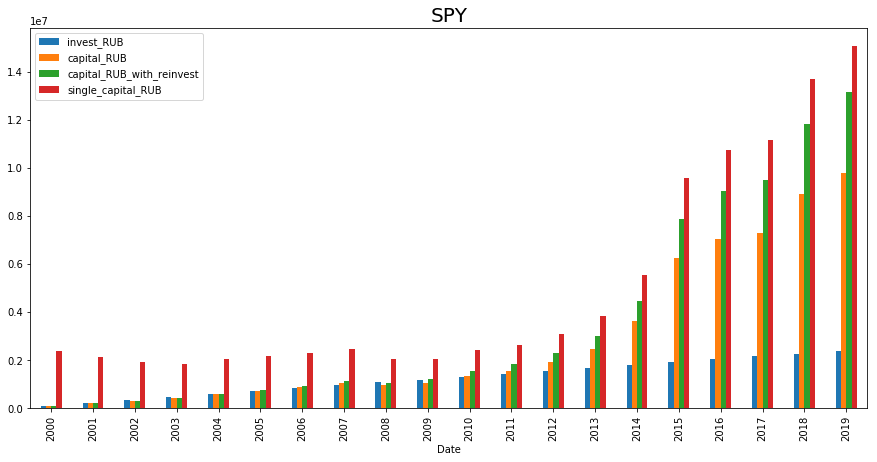

In [47]:
main[['invest_RUB', 'capital_RUB', 'capital_RUB_with_reinvest', 'single_capital_RUB']].plot.bar(figsize=(15,7))
plt.title(symbol, fontsize=20)

In [48]:
pd.set_option('display.precision',10)


In [49]:
main[['invest_RUB', 'capital_RUB', 'capital_RUB_with_reinvest', 'single_capital_RUB']]

,invest_RUB,capital_RUB,capital_RUB_with_reinvest,single_capital_RUB
Date,,,,
2000,120000,119851.12,119851.12,2397022.44
2001,240000,223654.20,223654.20,2117725.66
2002,360000,319360.20,325622.17,1922423.19
2003,480000,421925.96,436782.51,1848154.57
2004,600000,581792.02,611208.47,2059151.53
2005,720000,729030.63,776948.13,2190514.56
2006,840000,875481.58,946658.94,2309705.46
2007,960000,1046315.42,1148302.85,2485471.30
2008,1080000,960752.97,1076286.55,2040079.88


In [50]:
(main.invest_RUB / main.invest_USD)

Date
2000   27.91
2001   28.53
2002   29.42
2003   29.72
2004   29.53
2005   29.32
2006   28.99
2007   28.51
2008   28.05
2009   28.39
2010   28.56
2011   28.62
2012   28.80
2013   29.00
2014   29.49
2015   30.48
2016   31.49
2017   32.31
2018   33.16
2019   33.99
dtype: float64

In [51]:
main.Dollar_Rate / (main.invest_RUB / main.invest_USD)

Date
2000   1.00
2001   1.02
2002   1.07
2003   1.03
2004   0.98
2005   0.97
2006   0.94
2007   0.90
2008   0.89
2009   1.12
2010   1.06
2011   1.03
2012   1.08
2013   1.10
2014   1.31
2015   2.01
2016   2.12
2017   1.80
2018   1.90
2019   1.91
dtype: float64

In [52]:
main.Dollar_Rate

Date
2000   27.91
2001   29.18
2002   31.36
2003   30.67
2004   28.81
2005   28.31
2006   27.14
2007   25.55
2008   24.87
2009   31.77
2010   30.38
2011   29.39
2012   31.07
2013   31.91
2014   38.60
2015   61.32
2016   66.83
2017   58.30
2018   62.93
2019   64.82
Name: Dollar_Rate, dtype: float64

In [53]:
main

,Open,Dollar_Rate,stocks_count,Dividends,div_pay,stocks_with_reinvest,div_pay_with_reinvest,capital_USD,capital_RUB,capital_USD_with_reinvest,capital_RUB_with_reinvest,single_invest_RUB,single_invest_USD,single_stocks,single_div_pay,single_capital_USD,single_capital_RUB,invest_RUB,invest_USD
Date,,,,,,,,,,,,,,,,,,,
2000,143.14,27.91,30,1.31,39.28,30.00,39.30,4294.20,119851.12,4294.20,119851.12,2400000,85990.68,600.00,786.00,85884.00,2397022.44,120000,4299.53
2001,119.76,29.18,64,1.24,79.29,64.00,79.36,7664.64,223654.20,7664.64,223654.20,0,0.00,606.00,751.44,72574.56,2117725.66,240000,8411.94
2002,99.84,31.36,102,1.30,132.93,104.00,135.20,10183.68,319360.20,10383.36,325622.17,0,0.00,614.00,798.20,61301.76,1922423.19,360000,12238.47
2003,96.88,30.67,142,1.42,201.37,147.00,208.74,13756.96,421925.96,14241.36,436782.51,0,0.00,622.00,883.24,60259.36,1848154.57,480000,16151.09
2004,113.45,28.81,178,1.91,340.23,187.00,357.17,20194.10,581792.02,21215.15,611208.47,0,0.00,630.00,1203.30,71473.50,2059151.53,600000,20316.31
2005,120.90,28.31,213,1.87,398.23,227.00,424.49,25751.70,729030.63,27444.30,776948.13,0,0.00,640.00,1196.80,77376.00,2190514.56,720000,24555.09
2006,131.13,27.14,246,2.13,523.49,266.00,566.58,32257.98,875481.58,34880.58,946658.94,0,0.00,649.00,1382.37,85103.37,2309705.46,840000,28976.61
2007,147.84,25.55,277,2.35,650.91,304.00,714.40,40951.68,1046315.42,44943.36,1148302.85,0,0.00,658.00,1546.30,97278.72,2485471.30,960000,33673.29
2008,122.25,24.87,316,2.37,748.06,354.00,838.98,38631.00,960752.97,43276.50,1076286.55,0,0.00,671.00,1590.27,82029.75,2040079.88,1080000,38498.38


In [54]:
main[['Open', 'Dividends', 'single_invest_RUB', 'single_invest_USD', 'single_stocks', 'single_div_pay', 'single_capital_USD', 'single_capital_RUB']]

,Open,Dividends,single_invest_RUB,single_invest_USD,single_stocks,single_div_pay,single_capital_USD,single_capital_RUB
Date,,,,,,,,
2000,143.14,1.31,2400000,85990.68,600.00,786.00,85884.00,2397022.44
2001,119.76,1.24,0,0.00,606.00,751.44,72574.56,2117725.66
2002,99.84,1.30,0,0.00,614.00,798.20,61301.76,1922423.19
2003,96.88,1.42,0,0.00,622.00,883.24,60259.36,1848154.57
2004,113.45,1.91,0,0.00,630.00,1203.30,71473.50,2059151.53
2005,120.90,1.87,0,0.00,640.00,1196.80,77376.00,2190514.56
2006,131.13,2.13,0,0.00,649.00,1382.37,85103.37,2309705.46
2007,147.84,2.35,0,0.00,658.00,1546.30,97278.72,2485471.30
2008,122.25,2.37,0,0.00,671.00,1590.27,82029.75,2040079.88


In [55]:
# Во сколько раз увеличился капитал разововложенный в USD
main[['single_capital_USD']].loc[main.index.max()].values[0] / main[['single_capital_USD']].loc[main.index.min()].values[0]

2.705905407293559

Text(0.5, 1.0, 'SPY')

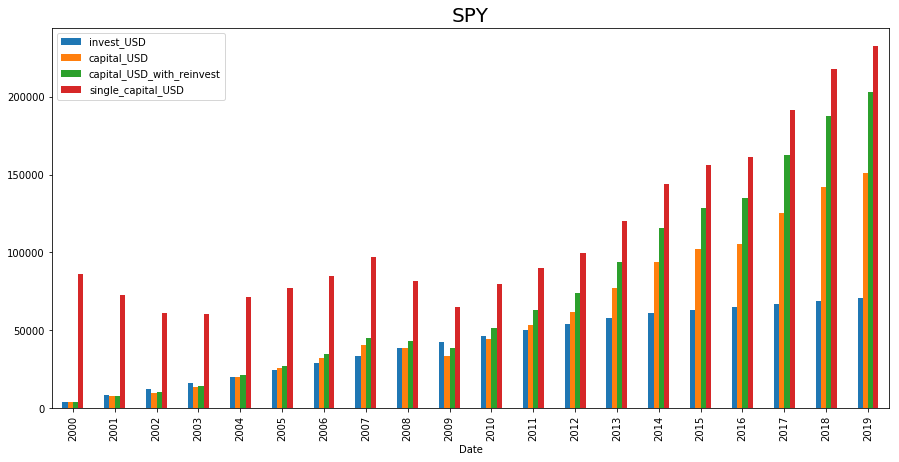

In [56]:
main[['invest_USD', 'capital_USD', 'capital_USD_with_reinvest', 'single_capital_USD']].plot.bar(figsize=(15,7))
plt.title(symbol, fontsize=20)


In [57]:
# Ежемесячные дивиденды в RUB при ежемесячном инвестировании
(main.div_pay_with_reinvest * main['Dollar_Rate'])[2019]/12

18595.561599999997

In [58]:
# Ежемесячные дивиденды в RUB при разовом инвестировании
(main.single_div_pay * main['Dollar_Rate'])[2019]/12

21289.804899999996

Text(0, 0.5, 'RUB in month')

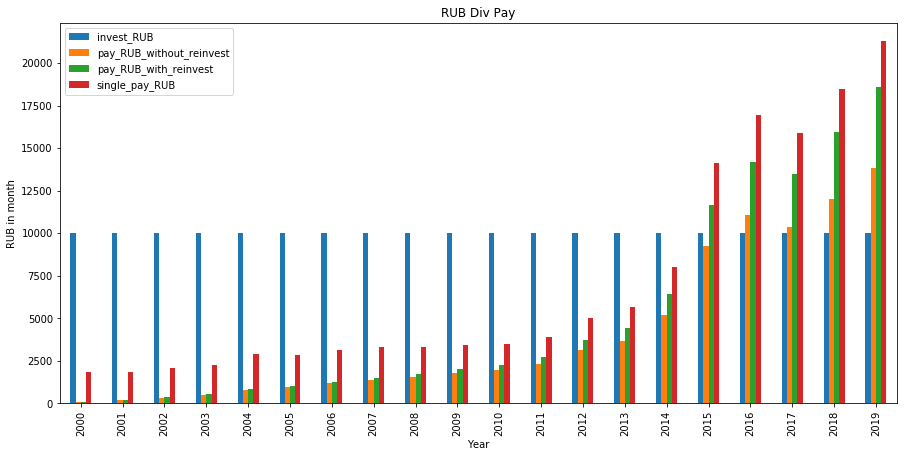

In [59]:
x1 = [INVEST_IN_MONTH for i in range(len(main))]
x2 = main.div_pay * main.Dollar_Rate / 12
x3 = main.div_pay_with_reinvest * main.Dollar_Rate / 12
x4 = main.single_div_pay * main.Dollar_Rate / 12

index = main.div_pay_with_reinvest.index
df_x1 = pd.DataFrame(x1, index=index)
df_x2 = pd.DataFrame(x2, index=index)
df_x3 = pd.DataFrame(x3, index=index)
df_x4 = pd.DataFrame(x4, index=index)
df_RUB_invest_pay = pd.merge(df_x1, df_x2, left_index=True, right_index=True)
df_RUB_invest_pay = pd.merge(df_RUB_invest_pay, df_x3, left_index=True, right_index=True)
df_RUB_invest_pay = pd.merge(df_RUB_invest_pay, df_x4, left_index=True, right_index=True)
df_RUB_invest_pay.columns = ['invest_RUB', 'pay_RUB_without_reinvest','pay_RUB_with_reinvest', 'single_pay_RUB']
df_RUB_invest_pay.plot.bar(figsize=(15,7))
plt.title('RUB Div Pay')
plt.xlabel('Year')
plt.ylabel('RUB in month')

Text(0, 0.5, 'USD in month')

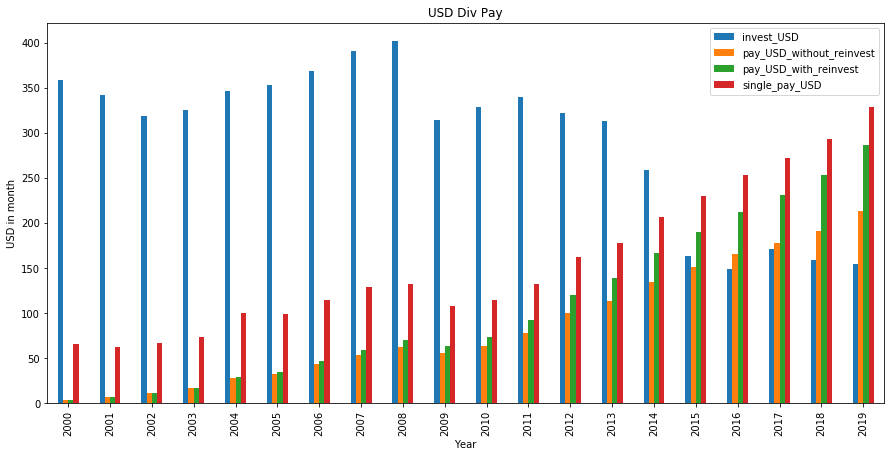

In [60]:
index = main.div_pay_with_reinvest.index
df_x1 = INVEST_IN_MONTH / main.Dollar_Rate
df_x2 = main.div_pay / 12
df_x3 = main.div_pay_with_reinvest / 12
df_x4 = main.single_div_pay / 12
df_USD_invest_pay = pd.merge(df_x1, df_x2, left_index=True, right_index=True)
df_USD_invest_pay = pd.merge(df_USD_invest_pay, df_x3, left_index=True, right_index=True)
df_USD_invest_pay = pd.merge(df_USD_invest_pay, df_x4, left_index=True, right_index=True)
df_USD_invest_pay.columns = ['invest_USD', 'pay_USD_without_reinvest','pay_USD_with_reinvest', 'single_pay_USD']
df_USD_invest_pay.plot.bar(figsize=(15,7))
plt.title('USD Div Pay')
plt.xlabel('Year')
plt.ylabel('USD in month')